In [ ]:
# EfficientNetV2-S
!pip install -q timm torch torchvision scikit-learn seaborn

import os, shutil, torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 👇 Replace with your actual Drive path
base_dir = '/content/drive/MyDrive/oral_cancer_dataset'  # contains OCA, OPMD, Benign, Healthy

merged_dir = '/content/oral_cancer_2class'
os.makedirs(os.path.join(merged_dir, 'Healthy'), exist_ok=True)
os.makedirs(os.path.join(merged_dir, 'Oral_Cancer'), exist_ok=True)

for src_cls, dest_cls in [
    ('OCA', 'Oral_Cancer'),
    ('OPMD', 'Oral_Cancer'),
    ('Benign', 'Healthy'),
    ('Healthy', 'Healthy')
]:
    src = os.path.join(base_dir, src_cls)
    if os.path.exists(src):
        for f in os.listdir(src):
            src_path = os.path.join(src, f)
            dst_path = os.path.join(merged_dir, dest_cls, f'{src_cls}_{f}')
            if os.path.isfile(src_path):
                shutil.copy(src_path, dst_path)

for cls in os.listdir(merged_dir):
    print(cls, "→", len(os.listdir(os.path.join(merged_dir, cls))), "images")


Mounted at /content/drive
Oral_Cancer → 1523 images
Healthy → 1478 images


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = datasets.ImageFolder(merged_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

print("Classes:", dataset.classes)


Classes: ['Healthy', 'Oral_Cancer']


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load pretrained EfficientNetV2-S from timm
model = timm.create_model('efficientnetv2_s', pretrained=False, num_classes=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Device: cpu


In [ ]:
epochs = 5
for epoch in range(epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0
    for imgs, labels in train_loader:
        try:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        except OSError as e:
            print(f"Skipping image due to error: {e}")
            continue  # Skip to the next iteration

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}%")

Epoch 1/5 | Loss: 1.0814 | Train Acc: 51.33%
Epoch 2/5 | Loss: 0.8750 | Train Acc: 54.29%
Epoch 3/5 | Loss: 0.8916 | Train Acc: 51.25%
Epoch 4/5 | Loss: 0.8125 | Train Acc: 54.17%
Epoch 5/5 | Loss: 0.8562 | Train Acc: 54.88%


In [ ]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print("\n✅ EfficientNetV2-S Performance:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print("\nDetailed Classification Report:\n", classification_report(y_true, y_pred, target_names=dataset.classes))



✅ EfficientNetV2-S Performance:
Accuracy : 0.5774
Precision: 0.5898
Recall   : 0.5668
F1-Score : 0.5781

Detailed Classification Report:
               precision    recall  f1-score   support

     Healthy       0.57      0.59      0.58       294
 Oral_Cancer       0.59      0.57      0.58       307

    accuracy                           0.58       601
   macro avg       0.58      0.58      0.58       601
weighted avg       0.58      0.58      0.58       601



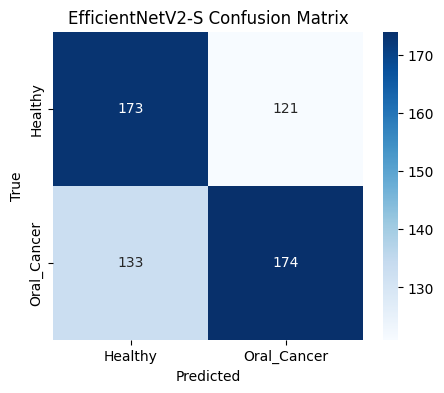

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EfficientNetV2-S Confusion Matrix')
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/efficientnetv2s_oral_cancer_model.pth')
print("✅ Model saved successfully!")


✅ Model saved successfully!
